# Compare OSSE for GLONet : Noised

In [1]:
import xarray as xr

## Load datasets

In [2]:
# 1. Load the analyzed forecast dataset
analyzed_forecast = xr.open_dataset("/Odyssey/private/j25lee/glonet/output/osse/case_2_noise/forecast_4days_from_2025-07-17_noised.nc")

# 2. Load the model dataset
model = xr.open_dataset("/Odyssey/private/j25lee/glonet/output/osse/case_2_noise/repeated_forecast_4days_from_2025-07-17.nc")

# 3. Load the glo12 dataset
path = "/Odyssey/public/glonet/2025-07-21_init_states_natureformat"# Read the three input files from the given path

input_list = ["input1.nc", "input2.nc", "input3.nc"]
input_files = [xr.open_dataset(f"{path}/{file}") for file in input_list]

depth_data = xr.concat([input_files[0].drop_vars(["zos"]).expand_dims(depth=[analyzed_forecast.depth[0].values]), input_files[1], input_files[2]], dim="depth")
final_data = xr.merge([input_files[0].zos.to_dataset(), depth_data])


In [3]:
corrected = analyzed_forecast.isel(time=-1)
glo12 = final_data.isel(time=-1)
normalrun = model.isel(time=-2)


### Investigate the data wether they are well selected
 ! It is important to see the variables and dimensions in order to right comparasion.

In [4]:
normalrun #glo12 #corrected

<xarray.Dataset> Size: 658MB
Dimensions:    (depth: 21, latitude: 672, longitude: 1440)
Coordinates:
  * depth      (depth) float32 84B 0.494 47.37 92.33 ... 4.833e+03 5.275e+03
  * latitude   (latitude) float64 5kB -78.0 -77.75 -77.5 ... 89.25 89.5 89.75
  * longitude  (longitude) float64 12kB -180.0 -179.8 -179.5 ... 179.5 179.8
    time       datetime64[ns] 8B 2025-07-20
Data variables:
    thetao     (depth, latitude, longitude) float64 163MB ...
    zos        (latitude, longitude) float64 8MB ...
    uo         (depth, latitude, longitude) float64 163MB ...
    vo         (depth, latitude, longitude) float64 163MB ...
    so         (depth, latitude, longitude) float64 163MB ...
Attributes:
    Conventions:  CF-1.8
    area:         Global
    contact:      glonet@mercator-ocean.eu
    institution:  Mercator Ocean International
    source:       MOI GLONET
    title:        daily mean fields from GLONET 1/4 degree resolution Forecas...
    references:   www.edito.eu

## Visualization of the difference


In [5]:
import matplotlib.pyplot as plt
    
def visualize_two_differences(ds1, ds2, ds3, var, depth_idx=0):
    """
    Visualize the difference (ds1 - ds3) and (ds2 - ds3) for a given variable and depth using subplots.
    Color scale min/max is fixed from ds3.
    """
    
    match var :
        case "zos" :
            cmap_param = "seismic"
        case "thetao" :
            cmap_param = "viridis"
        case "so" :
            cmap_param = "jet"
        case "uo" :
            cmap_param = "coolwarm"
        case "vo" :
            cmap_param = "coolwarm"
            
    a1 = ds1[var].rename(longitude='lon', latitude='lat')
    a2 = ds2[var].rename(longitude='lon', latitude='lat')
    b = ds3[var]
    
    if 'depth' in a1.dims:
        a1 = a1.isel(depth=depth_idx)
        a2 = a2.isel(depth=depth_idx)
        b = b.isel(depth=depth_idx)
        title1 = f'Difference: ds1 - ds3 ({var}, depth={a1.depth.values})'
        title2 = f'Difference: ds2 - ds3 ({var}, depth={a2.depth.values})'
    else:
        title1 = f'Difference: ds1 - ds3 ({var})'
        title2 = f'Difference: ds2 - ds3 ({var})'

    diff1 = a1 - b
    diff2 = a2 - b
    
    vmin = float(diff1.min().values)
    vmax = float(diff1.max().values)
    
    fig, axes = plt.subplots(1, 2, figsize=(16, 6))
    im1 = axes[0].pcolormesh(diff1['lon'], diff1['lat'], diff1.values, cmap=cmap_param, vmin=vmin, vmax=vmax)
    axes[0].set_title(title1)
    fig.colorbar(im1, ax=axes[0], label=f'{var} difference')
    im2 = axes[1].pcolormesh(diff2['lon'], diff2['lat'], diff2.values, cmap=cmap_param, vmin=vmin, vmax=vmax)
    axes[1].set_title(title2)
    fig.colorbar(im2, ax=axes[1], label=f'{var} difference')
    # plt.show()

    return vmin, vmax

Fix the third argument as the glo12. It is becuase of the difference dimensions name : <p>latitude => lat, longitude => lon</p>

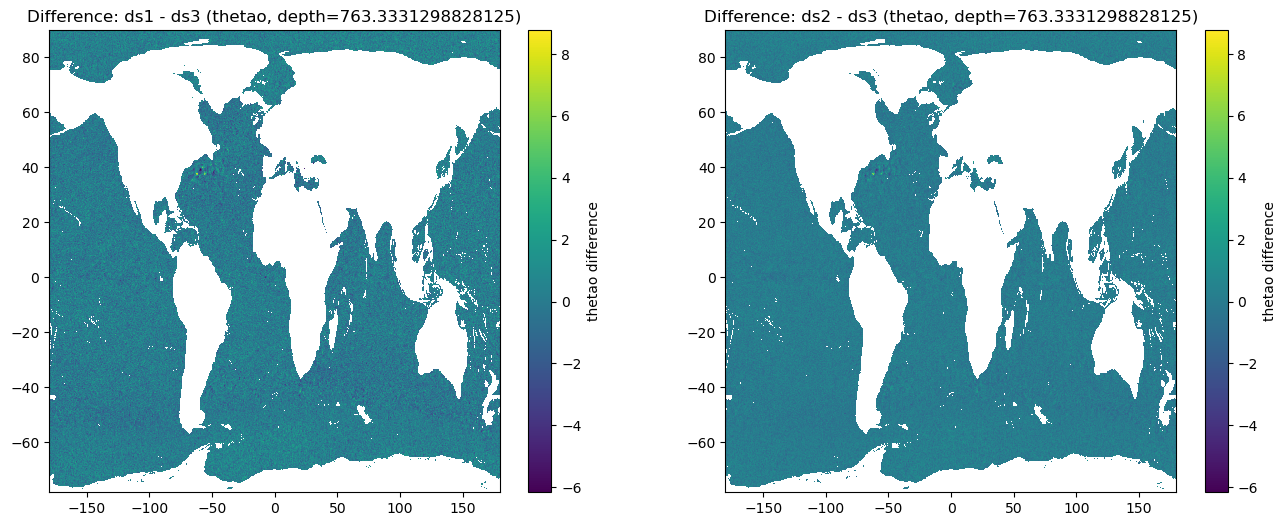

In [6]:
pmin, pmax = visualize_two_differences(normalrun, corrected, glo12, 'thetao', depth_idx=10)

### diffdiff
The visualization above is barely showing the difference. so let's diffdiff to look closer, but in same scale to faire comparaison.

In [7]:

def visualize_diffdifferences(ds1, ds2, pmin, pmax, var, depth_idx=0):
    """
    Visualize the difference (ds1 - ds3) and (ds2 - ds3) for a given variable and depth using subplots.
    Color scale min/max is fixed from ds3.
    """
    
    match var :
        case "zos" :
            cmap_param = "seismic"
        case "thetao" :
            cmap_param = "viridis"
        case "so" :
            cmap_param = "jet"
        case "uo" :
            cmap_param = "coolwarm"
        case "vo" :
            cmap_param = "coolwarm"
            
    a1 = ds1[var].rename(longitude='lon', latitude='lat')
    a2 = ds2[var].rename(longitude='lon', latitude='lat')
    
    if 'depth' in a1.dims:
        a1 = a1.isel(depth=depth_idx)
        a2 = a2.isel(depth=depth_idx)
        
        title1 = f'Difference: ds1 - ds3 ({var}, depth={a1.depth.values})'

    else:
        title1 = f'Difference: ds1 - ds3 ({var})'

    diffdiff = a1 - a2
    
    
    fig, axes = plt.subplots(1, 1, figsize=(10, 6))
    im1 = axes.pcolormesh(diffdiff['lon'], diffdiff['lat'], diffdiff.values, cmap=cmap_param, vmin=pmin, vmax=pmax)
    axes.set_title(title1)
    fig.colorbar(im1, ax=axes, label=f'{var} difference')

    # plt.show()

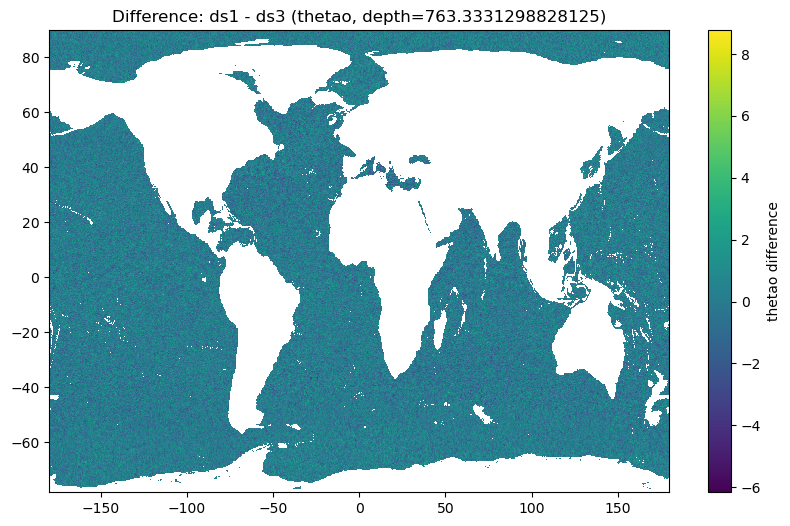

In [8]:
visualize_diffdifferences(normalrun, corrected, pmin, pmax, 'thetao', depth_idx=10)

# Quantification of the differences
Investigate the mean, absolute mean value, median, standard deviation, max and min values. </br>
 - Mean value has not much information given the data has both positive and negative values.

In [9]:
import numpy as np

def summarize_difference(forecast, truth):
    summary = {}
    for var in forecast.data_vars:
        if var not in truth.data_vars:
            continue
        a = forecast[var]
        coords_map = {}
        if 'latitude' in a.dims:
            coords_map['latitude'] = 'lat'
        if 'longitude' in a.dims:
            coords_map['longitude'] = 'lon'
        if coords_map:
            a = a.rename(coords_map)
        b = truth[var]
        if set(a.dims) != set(b.dims):
            print(f"Skipping {var}: dimension mismatch")
            continue
        if 'depth' in a.dims:
            stats = {}
            for i, d in enumerate(a.depth.values):
                diff = a.isel(depth=i) - b.isel(depth=i)
                stats[d] = {
                    'mean': float(diff.mean().values),
                    'mean_abs': float(np.abs(diff).mean().values),
                    'median': float(np.median(diff.values)),
                    'std': float(diff.std().values),
                    'max': float(diff.max().values),
                    'min': float(diff.min().values)
                }
            summary[var] = stats
        else:
            diff = a - b
            summary[var] = {
                'mean': float(diff.mean().values),
                'mean_abs': float(np.abs(diff).mean().values),
                'median': float(np.median(diff.values)),
                'std': float(diff.std().values),
                'max': float(diff.max().values),
                'min': float(diff.min().values)
            }
    return summary

In [10]:
def abs_mean_score(forecast, truth):
    """
    Calculate abs_mean(forecast - truth) / abs_mean(truth) and for each variable and by depth if present.
    Returns a dictionary of scores and stds.
    """
    import numpy as np
    score = {}
    for var in forecast.data_vars:
        if var not in truth.data_vars:
            continue
        a = forecast[var]
        coords_map = {}
        if 'latitude' in a.dims:
            coords_map['latitude'] = 'lat'
        if 'longitude' in a.dims:
            coords_map['longitude'] = 'lon'
        if coords_map:
            a = a.rename(coords_map)
        b = truth[var]
        if set(a.dims) != set(b.dims):
            print(f"Skipping {var}: dimension mismatch")
            continue
        if 'depth' in a.dims:
            scores = {}
            for i, d in enumerate(a.depth.values):
                diff = a.isel(depth=i) - b.isel(depth=i)
                abs_mean_diff = float(np.abs(diff).mean().values)
                abs_mean_truth = float(np.abs(b.isel(depth=i)).mean().values)
                # std_diff = float(diff.std().values)
                # std_truth = float(b.isel(depth=i).std().values)
                scores[d] = {
                    'abs_mean_score': abs_mean_diff / abs_mean_truth if abs_mean_truth != 0 else np.nan,
                    # 'std_score': std_diff / std_truth if std_truth != 0 else np.nan
                }
            score[var] = scores
        else:
            diff = a - b
            abs_mean_diff = float(np.abs(diff).mean().values)
            abs_mean_truth = float(np.abs(b).mean().values)
            # std_diff = float(diff.std().values)
            # std_truth = float(b.std().values)
            score[var] = {
                'abs_mean_score': abs_mean_diff / abs_mean_truth if abs_mean_truth != 0 else np.nan,
                # 'std_score': std_diff / std_truth if std_truth != 0 else np.nan
            }
    return score


## normalrun - glo12

### Sea surface height

In [11]:
diff_summary1 = summarize_difference(normalrun, glo12)
diff_summary1["zos"]

{'mean': -0.010114982828968852,
 'mean_abs': 0.04494945073770002,
 'median': nan,
 'std': 0.05917323726489484,
 'max': 0.6269700229167938,
 'min': -0.9703408032655716}

### Temperature, salinity and currents
Change the stat value and states to investigate by depth

In [12]:
# For all depths
{depth: stats['mean_abs'] for depth, stats in diff_summary1['thetao'].items()}


{np.float32(0.494025): 0.8221459595009639,
 np.float32(47.37369): 1.5144887055951655,
 np.float32(92.32607): 1.5294686829559494,
 np.float32(155.8507): 1.4051563851569464,
 np.float32(222.4752): 1.191798879433187,
 np.float32(318.1274): 0.8692586772482198,
 np.float32(380.213): 0.8699885086632825,
 np.float32(453.9377): 0.9522254294459471,
 np.float32(541.0889): 0.6503509132032036,
 np.float32(643.5668): 0.6441093650771909,
 np.float32(763.3331): 0.651517875794444,
 np.float32(902.3393): 1.8913119697527694,
 np.float32(1245.291): 1.2346318658541862,
 np.float32(1684.284): 1.564384084857382,
 np.float32(2225.078): 1.267001382160633,
 np.float32(3220.82): 0.6489556456080119,
 np.float32(3597.032): 0.5626860427422453,
 np.float32(3992.484): 0.44809520914460543,
 np.float32(4405.224): 0.5127219487592013,
 np.float32(4833.291): 0.3905282832300722,
 np.float32(5274.784): 1.616154344909902}

In [13]:

score_abs_mean1 = abs_mean_score(normalrun, glo12)
score_abs_mean1["thetao"]

{np.float32(0.494025): {'abs_mean_score': 0.05463973183394476},
 np.float32(47.37369): {'abs_mean_score': 0.11001552555886704},
 np.float32(92.32607): {'abs_mean_score': 0.12107355444730421},
 np.float32(155.8507): {'abs_mean_score': 0.1302313607023848},
 np.float32(222.4752): {'abs_mean_score': 0.1261342215306433},
 np.float32(318.1274): {'abs_mean_score': 0.10715962303527646},
 np.float32(380.213): {'abs_mean_score': 0.11750016460474245},
 np.float32(453.9377): {'abs_mean_score': 0.1424622811036529},
 np.float32(541.0889): {'abs_mean_score': 0.10910312279097897},
 np.float32(643.5668): {'abs_mean_score': 0.1220100516106107},
 np.float32(763.3331): {'abs_mean_score': 0.14130616835197304},
 np.float32(902.3393): {'abs_mean_score': 0.4773054795425393},
 np.float32(1245.291): {'abs_mean_score': 0.4125304223185236},
 np.float32(1684.284): {'abs_mean_score': 0.682460883939533},
 np.float32(2225.078): {'abs_mean_score': 0.7082481271477249},
 np.float32(3220.82): {'abs_mean_score': 0.5008813

## Corrected - glo12

In [14]:
diff_summary2 = summarize_difference(corrected, glo12)
diff_summary2["zos"]

{'mean': -0.008163393640435671,
 'mean_abs': 0.034150504425177246,
 'median': nan,
 'std': 0.04581168505042268,
 'max': 0.5953277945518494,
 'min': -1.0795779377222061}

In [15]:
{depth: stats['mean_abs'] for depth, stats in diff_summary2['thetao'].items()}

{np.float32(0.494025): 0.5731851305696489,
 np.float32(47.37369): 0.8299677238568766,
 np.float32(92.32607): 0.8139457590279496,
 np.float32(155.8507): 0.7194309295098449,
 np.float32(222.4752): 0.5988902112793991,
 np.float32(318.1274): 0.4411333420091445,
 np.float32(380.213): 0.43075768711225815,
 np.float32(453.9377): 0.4804049557139541,
 np.float32(541.0889): 0.34584875086138783,
 np.float32(643.5668): 0.33931915795655154,
 np.float32(763.3331): 0.3410175066399229,
 np.float32(902.3393): 0.922459210755825,
 np.float32(1245.291): 0.7258895355988049,
 np.float32(1684.284): 0.915736229973661,
 np.float32(2225.078): 0.7757377051566938,
 np.float32(3220.82): 0.36912812169792036,
 np.float32(3597.032): 0.3017209955959515,
 np.float32(3992.484): 0.1977947680734187,
 np.float32(4405.224): 0.29142573027900065,
 np.float32(4833.291): 0.16018537288296397,
 np.float32(5274.784): 1.052353305836367}

In [16]:
score_abs_mean2 = abs_mean_score(corrected, glo12)
score_abs_mean2["thetao"]

{np.float32(0.494025): {'abs_mean_score': 0.03809382198331355},
 np.float32(47.37369): {'abs_mean_score': 0.06029053567694191},
 np.float32(92.32607): {'abs_mean_score': 0.06443237921182142},
 np.float32(155.8507): {'abs_mean_score': 0.06667760960356293},
 np.float32(222.4752): {'abs_mean_score': 0.06338363954325596},
 np.float32(318.1274): {'abs_mean_score': 0.054381605700661896},
 np.float32(380.213): {'abs_mean_score': 0.05817789388760535},
 np.float32(453.9377): {'abs_mean_score': 0.07187330198095093},
 np.float32(541.0889): {'abs_mean_score': 0.05801972130167037},
 np.float32(643.5668): {'abs_mean_score': 0.06427533928153079},
 np.float32(763.3331): {'abs_mean_score': 0.07396247899640818},
 np.float32(902.3393): {'abs_mean_score': 0.23279863025759645},
 np.float32(1245.291): {'abs_mean_score': 0.2425431620218185},
 np.float32(1684.284): {'abs_mean_score': 0.39948895096325043},
 np.float32(2225.078): {'abs_mean_score': 0.4336339206656418},
 np.float32(3220.82): {'abs_mean_score': 0

### In certain region : Gulf stream
In global scheme, it is hard to tell the performance in reason of canceling out of data (positive + negative value and too many small values). </br>
So, let's investigate the region which has very active dynamic.

In [17]:
normalrun_gulf = normalrun.where((normalrun.longitude > -80) & (normalrun.longitude < -10) & 
                                 (normalrun.latitude > 30) & (normalrun.latitude < 50), drop=True)
corrected_gulf = corrected.where((corrected.longitude > -80) & (corrected.longitude < -10) & 
                                 (corrected.latitude > 30) & (corrected.latitude < 50), drop=True)
glo12_gulf = glo12.where((glo12.lon > -80) & (glo12.lon < -10) & 
                         (glo12.lat > 30) & (glo12.lat < 50), drop=True)

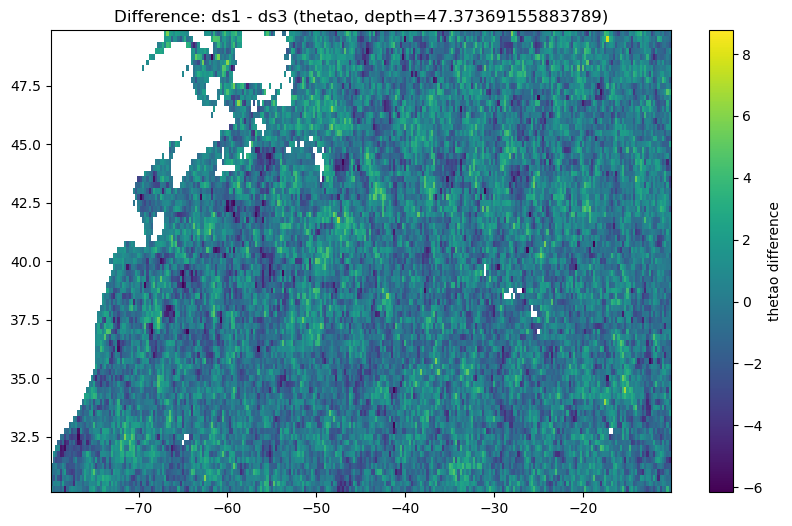

In [18]:
visualize_diffdifferences(normalrun_gulf, corrected_gulf, pmin, pmax, 'thetao', depth_idx=1)

In [19]:
diff_summary_gulf1 = summarize_difference(normalrun_gulf, glo12_gulf)
score_abs_mean_gulf1 = abs_mean_score(normalrun_gulf, glo12_gulf)
diff_summary_gulf2 = summarize_difference(corrected_gulf, glo12_gulf)
score_abs_mean_gulf2 = abs_mean_score(corrected_gulf, glo12_gulf)

In [20]:
# score_abs_mean_gulf1["zos"]
# score_abs_mean_gulf1["thetao"]
# score_abs_mean_gulf1["so"]
# score_abs_mean_gulf1["uo"]
score_abs_mean_gulf1["vo"]

{np.float32(0.494025): {'abs_mean_score': 0.6543980354794706},
 np.float32(47.37369): {'abs_mean_score': 0.7390828673073069},
 np.float32(92.32607): {'abs_mean_score': 0.6917634008684528},
 np.float32(155.8507): {'abs_mean_score': 0.6546674429607516},
 np.float32(222.4752): {'abs_mean_score': 0.6389124165021003},
 np.float32(318.1274): {'abs_mean_score': 0.6225970211776042},
 np.float32(380.213): {'abs_mean_score': 0.6137016494098914},
 np.float32(453.9377): {'abs_mean_score': 0.6191594480048891},
 np.float32(541.0889): {'abs_mean_score': 0.6271686864704523},
 np.float32(643.5668): {'abs_mean_score': 0.6446263262154233},
 np.float32(763.3331): {'abs_mean_score': 0.6812479091959395},
 np.float32(902.3393): {'abs_mean_score': 1.211552616089135},
 np.float32(1245.291): {'abs_mean_score': 1.4411532450309046},
 np.float32(1684.284): {'abs_mean_score': 1.6095910560123694},
 np.float32(2225.078): {'abs_mean_score': 1.1410658093304011},
 np.float32(3220.82): {'abs_mean_score': 1.44510280848416

In [21]:
# score_abs_mean_gulf2["zos"]
# score_abs_mean_gulf2["thetao"]
# score_abs_mean_gulf2["so"]
# score_abs_mean_gulf2["uo"]
score_abs_mean_gulf2["vo"]

{np.float32(0.494025): {'abs_mean_score': 0.4882216691216749},
 np.float32(47.37369): {'abs_mean_score': 0.44913943239267634},
 np.float32(92.32607): {'abs_mean_score': 0.4219575126411509},
 np.float32(155.8507): {'abs_mean_score': 0.4013893762330669},
 np.float32(222.4752): {'abs_mean_score': 0.38851793234992865},
 np.float32(318.1274): {'abs_mean_score': 0.380128010664311},
 np.float32(380.213): {'abs_mean_score': 0.3760466090723888},
 np.float32(453.9377): {'abs_mean_score': 0.3763870048484455},
 np.float32(541.0889): {'abs_mean_score': 0.38282474710300285},
 np.float32(643.5668): {'abs_mean_score': 0.3971932147416587},
 np.float32(763.3331): {'abs_mean_score': 0.42438081270982075},
 np.float32(902.3393): {'abs_mean_score': 0.8142055568874123},
 np.float32(1245.291): {'abs_mean_score': 0.8748254686331893},
 np.float32(1684.284): {'abs_mean_score': 0.891311802271138},
 np.float32(2225.078): {'abs_mean_score': 0.7340533032453095},
 np.float32(3220.82): {'abs_mean_score': 0.93382136513